# Monte Carlo Simulation of Prices of Coupon-Bearing Bond using CIR

As we have seen in the previous sessions, if we are fully funded, the best way to ensure that you will remain fully funded and be able to meet your liabilities is to build a portfolio of immunized bonds that are designed to match the future liability cash flows.

In practice, few of us, both in a Pension Fund context and even more so in a Personal Investment context, already have the assets to fund all future liabilities. Other than in cases where 100% funding ratios are mandated by law, the far more common situation is that we typically do not have the assets we need to fully fund our future liabilities.

That is where we need to allocate the wealth that we do have between the Performance Seekeng Component, and the Goal Hedging Component that we have already seen.

Therefore the next steps for us are to allocate our capital across two assets: the PSP and the GHP. The PSP, or Performance Seeking Portfolio, is where we consciously take some risk in the hope that the extra risk is well rewarded - in other words, a high Sharpe Ratio portfolio. The GHP or Goal Hedging Portfolio is the immnized bond portfolio that designed to protect us in case the worst case happens and we do not get the returns that we hope for from the PSP.

This of course raises the question of how much to allocate to the PSP and how much to the GHP. Clearly, allocating more to the PSP entails a higher expected return but a higher degree of risk. On the other hand, allocating too little to the PSP means less risk, but lower expected return. Thus, the decision of how much to allocate to the PSP vs the GHP is essentially a risk budgeting exercise.

We'll start out by developing the framework and in the next few lab sessions, examine different risk budgeting options.

First, we'll need to make a choice of the PSP. For now, we'll start with something fairly simple, which is the Geometric Brownian Motion based random stock portfolios. Much of the second MOOC in this series is focused on how to build good PSPs in practice.

However, we'll also need to pick a GHP. We can use Zero Coupon Bonds driven by random changes in interest rates using the CIR model. Since these are Zero Coupon, they are already immunized against interest rates if they are held to maturity. In practice, we've seen that even if we arent able to buy Zero Coupon bonds, we can construct bond portfolios that are designed to be insensitive to interest rates through duration matching.

In this section, we'll develop the code necessary to simulate bond prices of coupon-bearing bonds and see how their prices change as interest rates fluctuate. We'll limit ourselves to Treasury Bonds and ignore credit risk (i.e. the risk of default on the Bond).

In [3]:
import numpy as np
import pandas as pd
import sys
sys.path.append("../")
import edhec_risk_kit as erk
%matplotlib inline
%load_ext autoreload
%autoreload 2


Note that when interest rates rise, it is a fallacy that holding an allocation to bonds will give you the benefit of that increase. In fact, the opposite happens since the price of the bond will fall, and as a result your account sill suffer a capital loss.

Let's examine what happens to your wealth when you use a portfolio of stocks and bonds over a 5 year period.

For simplicity, we'll assume you are holding a bond that has a maturity of 5 years and for simplicity with avoiding intra-coupon caclulations, let's assume it pays a 5% coupon and the coupon is paid out each month and interest rates change from 3% to 3.2%


In [4]:
erk.bond_price(5,100,.05,12,.03)

0    109.275393
dtype: float64

In [5]:
erk.bond_price(5,100,.05,12,.032)

0    108.306703
dtype: float64

Now, let's compute the bond price with our simulated rates. We'll need to slightly generalize our `bond_prices` code to support vectors ...

```python
erk.bond_price(5,100,.05,12, rates.iloc[0]) ### returns an error
# because of this:
def discount(t, r):
    """
    Compute the price of a pure discount bond that pays a dollar at time t where t is in years and r is the annual interest rate
    """
    return (1+r)**(-t)
# error
discount(r.index, r) 
```

Instead, we'll modify `discount` to return a DataFrame by iterating over all given interest rates. Note that this is not a time series of interest rates, or a yield curve - it's just a vector of interest rates and the discount factor is recomputed for each interest rate


In [6]:
def discount(t, r):
    """
    Compute the price of a pure discount bond that pays a dollar at time period t
    and r is the per-period interest rate
    returns a |t| x |r| Series or DataFrame
    r can be a float, Series or DataFrame
    returns a DataFrame indexed by t
    """
    discounts = pd.DataFrame([(r+1)**-i for i in t])
    discounts.index = t
    return discounts

Next, we also need to update the Present Value code to support DataFrames

```python
def pv(flows, r):
    """
    Compute the present value of a sequence of cash flows given by the time (as an index) and amounts
    r can be a scalar, or a Series or DataFrame with the number of rows matching the num of rows in flows
    """
    dates = flows.index
    discounts = discount(dates, r)
    return (discounts*flows).sum()
```
needs to be replaced by

```python
def pv(flows, r):
    """
    Compute the present value of a sequence of cash flows given by the time (as an index) and amounts
    r can be a scalar, or a Series or DataFrame with the number of rows matching the num of rows in flows
    """
    dates = flows.index
    discounts = discount(dates, r)
    return discounts.multiply(flows, axis='rows').sum()

```

(Note: This will impact other functions that use `erk.discount()` such as `erk.macaulay_duration`, which I have also updated in the library, but it won't be used in this lab session)

In [7]:
erk.bond_price(5,100,.05,12, .03)

0    109.275393
dtype: float64

We'll generate interest rates using the CIR model:

In [8]:
rates, zc_prices = erk.cir(10, 500, b=0.03, r_0 = 0.03)

When we start out, all rates are at 3% and so the prices are all the same:

In [9]:
erk.bond_price(5,100,.05,12, rates.iloc[0][[1,2,3]])

1    109.275393
2    109.275393
3    109.275393
dtype: float64

In [10]:
rates[[1,2,3]].head()

,1,2,3
0,0.030000,0.030000,0.030000
1,0.032335,0.033101,0.033965
2,0.031463,0.033010,0.032310
3,0.027527,0.039170,0.034239
4,0.028271,0.040905,0.027733


At t=0 interest rates are the same across all scenarios. However at the first step, we see that (i) the maturity decreases and (ii) interest rates change, and so the bond prices diverge:

In [20]:
erk.bond_price(5,100,.05,12, rates.iloc[1])

0      109.164585
1      108.145272
2      107.777493
3      107.363953
4      110.912338
          ...    
495    111.788075
496    107.984170
497    106.995404
498    110.191623
499    108.903366
Length: 500, dtype: float64

In [11]:
erk.bond_price(5-1/12,100,.05,12, rates.iloc[1][[1,2,3]])

1    108.020014
2    107.658121
3    107.251174
dtype: float64

Therefore, we can now generate the bond prices at time 0:

In [12]:
erk.bond_price(5, 100, .05, 12, rates.iloc[0]).tail()

495    109.275393
496    109.275393
497    109.275393
498    109.275393
499    109.275393
dtype: float64

And at time t=1

In [13]:
erk.bond_price(5-1/12, 100, .05, 12, rates.iloc[1]).tail()

495    111.603380
496    107.861492
497    106.888478
498    110.033228
499    108.765908
dtype: float64

### Simulating Prices of a Coupon-bearing Bond

Now that we have the rates over time and the ability to compute bond prices from rates, we can stitch together the prices of a bond over time:

```python
def bond_price(maturity, principal=100, coupon_rate=0.03, coupons_per_year=12, discount_rate=0.03):
    """
    Computes the price of a bond that pays regular coupons until maturity
    at which time the principal and the final coupon is returned
    This is not designed to be efficient, rather,
    it is to illustrate the underlying principle behind bond pricing!
    """
    cash_flows = bond_cash_flows(maturity, principal, coupon_rate, coupons_per_year)
    return pv(cash_flows, discount_rate/coupons_per_year)
```

to

```python
def bond_price(maturity, principal=100, coupon_rate=0.03, coupons_per_year=12, discount_rate=0.03):
    """
    Computes the price of a bond that pays regular coupons until maturity
    at which time the principal and the final coupon is returned
    This is not designed to be efficient, rather,
    it is to illustrate the underlying principle behind bond pricing!
    If discount_rate is a DataFrame, then this is assumed to be the rate on each coupon date
    and the bond value is computed over time.
    i.e. The index of the discount_rate DataFrame is assumed to be the coupon number
    """
    if isinstance(discount_rate, pd.DataFrame):
        pricing_dates = discount_rate.index
        prices = pd.DataFrame(index=pricing_dates, columns=discount_rate.columns)
        for t in pricing_dates:
            prices.loc[t] = bond_price(maturity-t/coupons_per_year, principal, coupon_rate, coupons_per_year,
                                      discount_rate.loc[t])
        return prices
    else: # base case ... single time period
        if maturity <= 0: return principal+principal*coupon_rate/coupons_per_year
        cash_flows = bond_cash_flows(maturity, principal, coupon_rate, coupons_per_year)
        return pv(cash_flows, discount_rate/coupons_per_year)
```


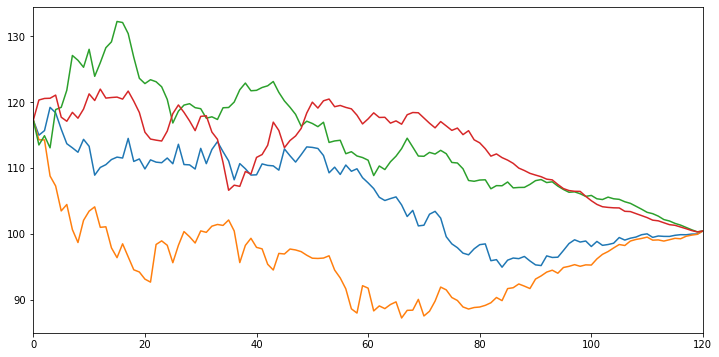

In [14]:
erk.bond_price(10, 100, .05, 12, rates[[1,2,3,4]]).plot(legend=False, figsize=(12,6))

In [25]:
prices = erk.bond_price(10, 100, .05, 12, rates[[1,2,3,4]])
prices.head()

,1,2,3,4
0,117.26,117.26,117.26,117.26
1,114.97,114.269,113.484,120.315
2,115.661,114.249,114.886,120.55
3,119.198,108.765,113.049,120.579
4,118.361,107.252,118.862,121.058


You might be tempted to think that since we have bond prices, we can generate returns as usual, by using `.pct_change().dropna()`.

In [16]:
br = prices.pct_change().dropna()
erk.annualize_rets(br, 12)

1   -0.015387
2   -0.015387
3   -0.015387
4   -0.015387
dtype: float64

The reason a 3% interest rate regime is yielding a -1.5% return in these 4 scenarios is that this is the _price return_. Because the interest rate at the time we bought it was less than the coupon rate, we bought it at a premium, taking a capital loss when we sold it at the end. We need to compute the Total Return of a bond, which is the price return PLUS the dividend:

```python
def bond_total_return(monthly_prices, principal, coupon_rate, coupons_per_year):
    """
    Computes the total return of a Bond based on monthly bond prices and coupon payments
    Assumes that dividends (coupons) are paid out at the end of the period (e.g. end of 3 months for quarterly div)
    and that dividends are reinvested in the bond
    """
    coupons = pd.DataFrame(data = 0, index=monthly_prices.index, columns=monthly_prices.columns)
    t_max = monthly_prices.index.max()
    pay_date = np.linspace(12/coupons_per_year, t_max, int(coupons_per_year*t_max/12), dtype=int)
    coupons.iloc[pay_date] = principal*coupon_rate/coupons_per_year
    total_returns = (monthly_prices + coupons)/monthly_prices.shift()-1
    return total_returns.dropna()
```


In [17]:
p = erk.bond_price(10, 100, .05, 12, rates[[1,2,3,4]])
btr = erk.bond_total_return(p, 100, .05, 12)
erk.annualize_rets(btr, 12)

1    0.032510
2    0.037264
3    0.029022
4    0.029190
dtype: float64

Which gives us the approximately 3% return we expected, because that was the prevailing rate when we bought it. We also assumed that we reinvested the coupon in the bond and that is why we did not get the exact same return in each case, since we would observe prices based on the then-prevalent interest rates.

## Putting it all together: Monte Carlo Simulation of Asset Allocation

Now that we have a way to generate prices from which to derive returns, we can experiment with allocating across the different Asset Classes.

Let's start by examining the performance of a 70-30 allocation to Stocks and Bonds. Assume Stocks return an average of 7% per year with a 15% vol and use the CIR model to generate bond prices for a 10 year and 30 year bond that pays a 5% coupon. For simplicity, assume the coupon is paid monthly to avoid having to deal with partial coupons. Assume the Bond Portfolio consists of 60% in the 10 year bond and 40% in the 30 year bond.

In [16]:
price_10 = erk.bond_price(10, 100, .05, 12, rates)
price_10[[1,2,3]].tail()

,1,2,3
116,100.931,99.6971,99.7447
117,100.728,99.5892,99.8878
118,100.534,99.848,99.8859
119,100.257,99.8723,99.9098
120,100.417,100.417,100.417


In [17]:
price_30 = erk.bond_price(30, 100, .05, 12, rates)
price_30[[1,2,3]].tail()

,1,2,3
116,145.978,89.1367,90.7392
117,148.297,81.556,94.4565
118,154.329,89.1988,91.737
119,151.583,82.7959,87.4065
120,148.36,88.0787,85.945


In [18]:
rets_30 = erk.bond_total_return(price_30, 100, .05, 12)
rets_10 = erk.bond_total_return(price_10, 100, .05, 12)

Now we can assume monthly rebalancing and compute the monthly returns of the bond portfolio:

In [19]:
rets_bonds = .6*rets_10 + .4*rets_30
mean_rets_bonds = rets_bonds.mean(axis='columns')
erk.summary_stats(pd.DataFrame(mean_rets_bonds))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.036232,0.003762,0.158128,3.309178,-0.001248,-0.000813,1.61248,0.0


In [20]:
price_eq = erk.gbm(n_years=10,n_scenarios=500,mu=0.07, sigma=0.15)
price_eq.shape

(121, 500)

In [21]:
rets_eq = price_eq.pct_change().dropna()
rets_eq.shape

(120, 500)

In [22]:
rets_bonds.shape

(120, 500)

In [23]:
rets = .70*rets_eq + 0.3*rets_bonds
rets_mean = rets.mean(axis='columns')
erk.summary_stats(pd.DataFrame(rets_mean))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.058481,0.004743,-0.122342,3.134724,-0.002462,-0.001897,5.844109,0.0
